<a href="https://colab.research.google.com/github/jxin11/waste-image-classification/blob/main/Waste_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Import Libraries

In [1]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install helper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2
import glob
import random
import visualkeras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow import keras
from keras.utils import np_utils
from collections import Counter, OrderedDict
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Optimizer, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                                    Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score

# Read & Store Images

In [5]:
!git clone https://github.com/garythung/trashnet

fatal: destination path 'trashnet' already exists and is not an empty directory.


In [ ]:
!unzip /content/trashnet/data/dataset-resized.zip

In [7]:
SIZE = 128

filepath = []
images = []
labels = []

# Read & Sort filepath
for folder_path in glob.glob("/content/dataset-resized/*"):
  for img_path in glob.glob(folder_path + "/*.jpg"):
    filepath.append(img_path)
  
filepath.sort()

# Read images & labels
for img_path in filepath:
  label = img_path.split("/")[-2]
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))   # Resize image
  images.append(img)
  labels.append(label)

In [8]:
print("Total no. of images: ", len(images))
print("Total no. of labels: ", len(labels))
print("Total no. of unique labels: ", Counter(labels))

Total no. of images:  2527
Total no. of labels:  2527
Total no. of unique labels:  Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})


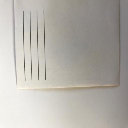

paper


In [9]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

# Prepare Train & Test Sets

In [10]:
# Shuffle images
temp = list(zip(images, labels))
random.Random(0).shuffle(temp)
res1, res2 = zip(*temp)
images, labels = list(res1), list(res2)

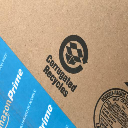

cardboard


In [11]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

In [12]:
# Train test split
img_train, img_test, label_train, label_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=0)

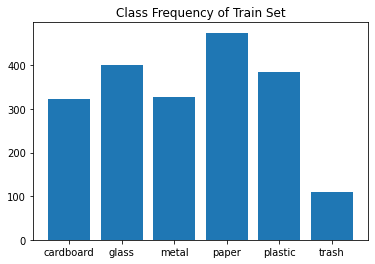


Train Set
cardboard: 322 (15.93%)
glass: 401 (19.84%)
metal: 328 (16.23%)
paper: 475 (23.5%)
plastic: 385 (19.05%)
trash: 110 (5.44%)


In [13]:
# Plot Class Freqeuncy of Train Set
c_train = OrderedDict(sorted(Counter(label_train).items()))
plt.bar(c_train.keys(), c_train.values())
plt.title("Class Frequency of Train Set")
plt.show()

print("\nTrain Set")
for i, v in enumerate(c_train):
  print(f"{v}: {c_train[v]} ({round(c_train[v]/sum(c_train.values())*100,2)}%)")

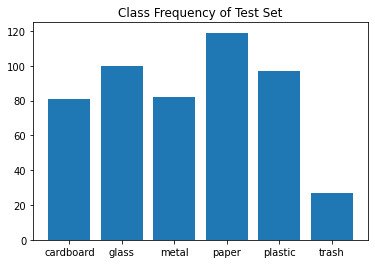


Test Set
cardboard: 81 (16.01%)
glass: 100 (19.76%)
metal: 82 (16.21%)
paper: 119 (23.52%)
plastic: 97 (19.17%)
trash: 27 (5.34%)


In [14]:
# Plot Class Freqeuncy of Train Set
c_test = OrderedDict(sorted(Counter(label_test).items()))
plt.bar(c_test.keys(), c_test.values())
plt.title("Class Frequency of Test Set")
plt.show()

print("\nTest Set")
for i, v in enumerate(c_test):
  print(f"{v}: {c_test[v]} ({round(c_test[v]/sum(c_test.values())*100,2)}%)")

# Convert to numpy array

In [15]:
# Before conversion
print("X_train: ", "type-", type(img_train), "; size-", len(img_train))
print("y_train: ", "type-", type(label_train), "; size-", len(label_train))

X_train:  type- <class 'list'> ; size- 2021
y_train:  type- <class 'list'> ; size- 2021


In [16]:
img_train = np.array(img_train, dtype="float")
img_test = np.array(img_test, dtype="float")
label_train = np.array(label_train)
label_test = np.array(label_test)

In [17]:
# After conversion
print("X_train: ", "type-", type(img_train), "; size-", img_train.shape)
print("y_train: ", "type-", type(label_train), "; size-", label_train.shape)

X_train:  type- <class 'numpy.ndarray'> ; size- (2021, 128, 128, 3)
y_train:  type- <class 'numpy.ndarray'> ; size- (2021,)


# Label Encoding

In [18]:
le = preprocessing.LabelEncoder()
le.fit(label_train)

LabelEncoder()

In [19]:
label_encoded_train = le.transform(label_train)
label_encoded_test = le.transform(label_test)

In [20]:
le.classes_

array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      dtype='<U9')

# One Hot Encoding

In [21]:
n_classes = len(le.classes_)

print("Shape before OHE: ", label_encoded_train.shape)

label_encoded_train = np_utils.to_categorical(label_encoded_train,n_classes)
label_encoded_test = np_utils.to_categorical(label_encoded_test,n_classes)

print("Shape after OHE: ", label_encoded_train.shape)

Shape before OHE:  (2021,)
Shape after OHE:  (2021, 6)


# Normalization



In [22]:
img_train, img_test = img_train/255.0, img_test/255.0

# Data Augmentation
Ref: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Data augmentation is only applied to train set.

In [23]:
datagen = ImageDataGenerator(rotation_range=20, 
                             horizontal_flip=True, vertical_flip=True,
                             zoom_range=0.2, shear_range=0.2)

**batch_size in ImageDataGenerator.flow - If you have 1000 images in your dataset and the batch size is defined as 10. Then the "ImageDataGenerator" will produce 10 images in each iteration of the training.

Original Image: 


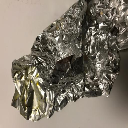


Data Augmentation: 


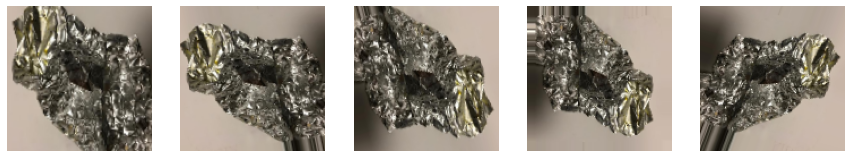

In [24]:
# Take an image as example

print("Original Image: ")
cv2_imshow(img_train[123]*255)

width, height, channel = img_train.shape[1], img_train.shape[2], img_train.shape[3]
iter = datagen.flow((img_train[123]).reshape(1, width, height, channel), batch_size=1)

# generate samples and plot
print("\nData Augmentation: ")
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

# generate batch of images
for i in range(5):

  image = next(iter)
  image = np.squeeze(image)
  
  # plot image
  ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

# Deep Learning Model Components
Ref: 
1. https://medium.com/the-owl/building-inception-resnet-v2-in-keras-from-scratch-a3546c4d93f0
2. https://arxiv.org/abs/1602.07261

## Convolutional Block

In [25]:
def conv2d(x, filters, kernel_size, strides=1, pad='same', act=True, name=None):
  x = Conv2D(filters=filters, kernel_size=kernel_size,
             strides=strides, padding=pad,
             data_format='channels_last', use_bias=False, 
             kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
             name=name+'conv2d')(x)
  x = BatchNormalization(axis=3, scale=False, name=name+'conv2d_bn')(x)
  if act:
    x = Activation('relu', name=name+'conv2d_act')(x)
  return x

Batch Norm reduces the internal covariate shift of the network. <br>
Batch Norm has a regularization effect. <br>
In CNN, each feature map will have a single mean and standard deviation. <br>
The original paper talks about applying batch norm just before the activation function, it has been found in practice that applying batch norm after the activation yields better results. <br>
Ref: 
1. https://www.baeldung.com/cs/batch-normalization-cnn
2. https://blog.paperspace.com/busting-the-myths-about-batch-normalization/

## Inception ResNet A Block

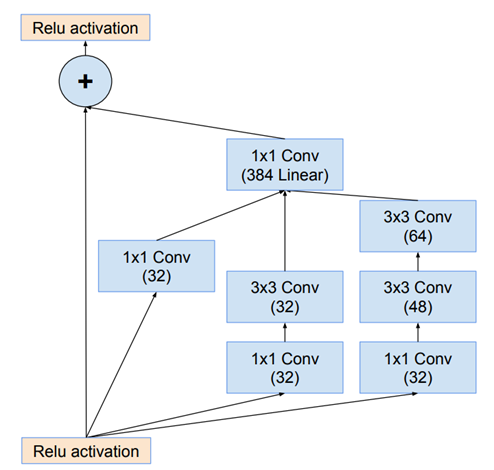

In [26]:
def incResA(x, scale, name=None):

  branch0 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 32, 3, 1, 'same', True, name=name+'b1_2')

  branch2 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 48, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, 64, 3, 1, 'same', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 384, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet B Block

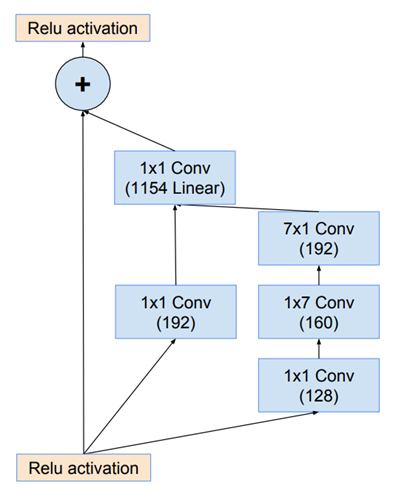

** _filt_exp_1x1 --> from 1154 chg to 1152 filters

In [27]:
def incResB(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 128, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 160, [1,7], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 192, [7,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 1152, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet C Block

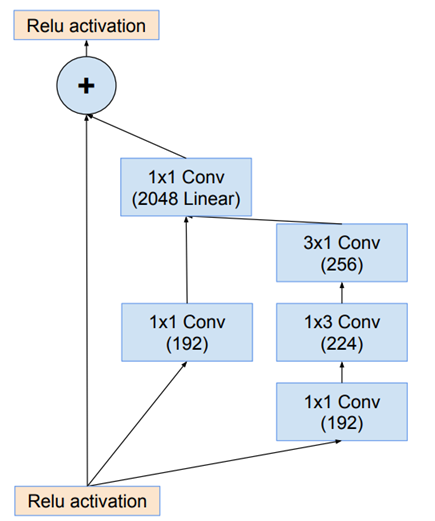

In [28]:
def incResC(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 224, [1,3], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 256, [3,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 2048, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Reduction A Block

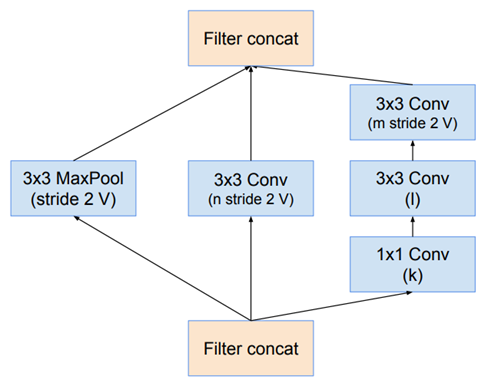

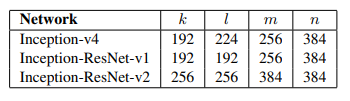

In [29]:
def redA(x, name=None):

  n = 384; k = 256; l = 256; m = 384

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, n, 3, 2, 'valid', True, name=name+'b1')

  branch2 = conv2d(x, k, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, l, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, m, 3, 2, 'valid', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

  return final_lay

## Reduction B Block

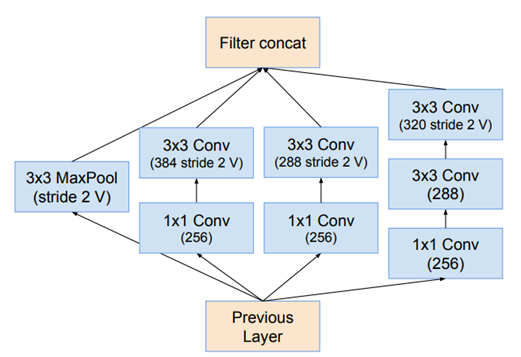

**layers b2_2, b3_2 and b3_3: # kernels --> 256

In [30]:
def redB(x, name=None):

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 384, 3, 2, 'valid', True, name=name+'b1_2')

  branch2 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 256, 3, 2, 'valid', True, name=name+'b2_2')

  branch3 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b3_1')
  branch3 = conv2d(branch3, 256, 3, 1, 'same', True, name=name+'b3_2')
  branch3 = conv2d(branch3, 256, 3, 2, 'valid', True, name=name+'b3_3')

  branches = [branch0, branch1, branch2, branch3]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

  return final_lay

## Stem Block

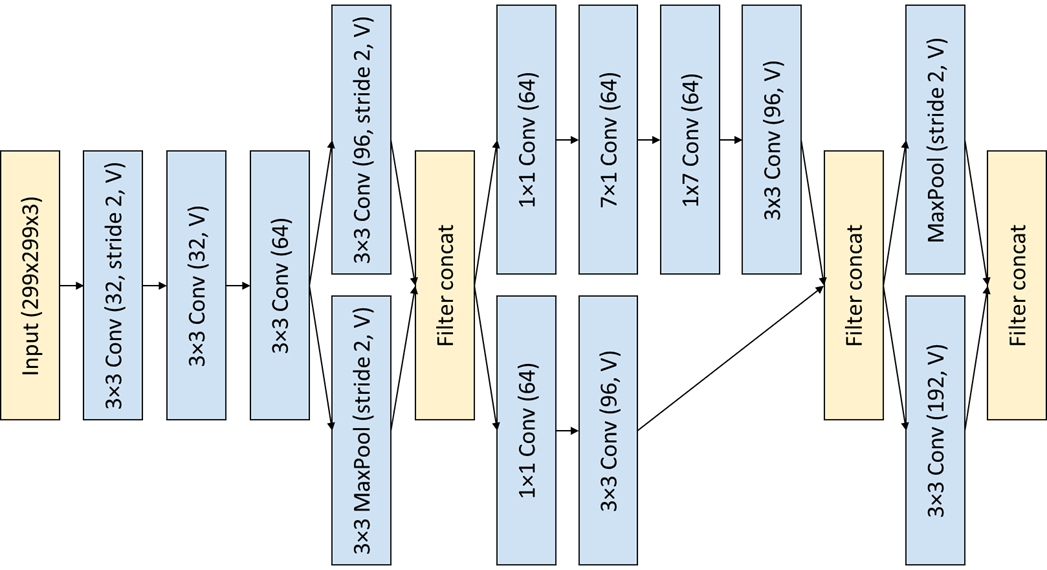

** layer stem_br_32 --> MaxPool, kernel_size = (3,3), stride = 1, 'valid'

In [31]:
def stem(img_input):

  x = conv2d(img_input, 32, 3, 2, 'valid', True, name='conv1')
  x = conv2d(x, 32, 3, 1, 'valid', True, name='conv2')
  x = conv2d(x, 64, 3, 1, 'same', True, name='conv3')
  
  x_11 = MaxPooling2D((3,3), 2, 'valid', name='stem_br_11')(x)
  x_12 = conv2d(x, 96, 3, 2, 'valid', True, name='stem_br_12')
  
  x_1 = [x_11, x_12]
  x = Concatenate(axis=3, name='stem_filt_concat1')(x_1)
  
  x_21 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_211')
  x_21 = conv2d(x_21, 96, 3, 1, 'valid', True, name='stem_br_212')

  x_22 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_221')
  x_22 = conv2d(x_22, 64, [7,1], 1, 'same', True, name='stem_br_222')
  x_22 = conv2d(x_22, 64, [1,7], 1, 'same', True, name='stem_br_223')
  x_22 = conv2d(x_22, 96, 3, 1, 'valid', True, name='stem_br_224')

  x_2 = [x_21, x_22]
  x = Concatenate(axis=3, name='stem_filt_concat2')(x_2)
  
  x_31 = conv2d(x, 192, 3, 1, 'valid', True, name='stem_br_31')  # 51 51 192 
  x_32 = MaxPooling2D((3,3), 1, 'valid', name='stem_br_32')(x)   # 27 27 192  26 26 192

  x_3 = [x_31, x_32]
  x = Concatenate(axis=3, name='stem_filt_concat3')(x_3)
  
  return x

# Deep Learning Model - Inception ResNetV2 Model

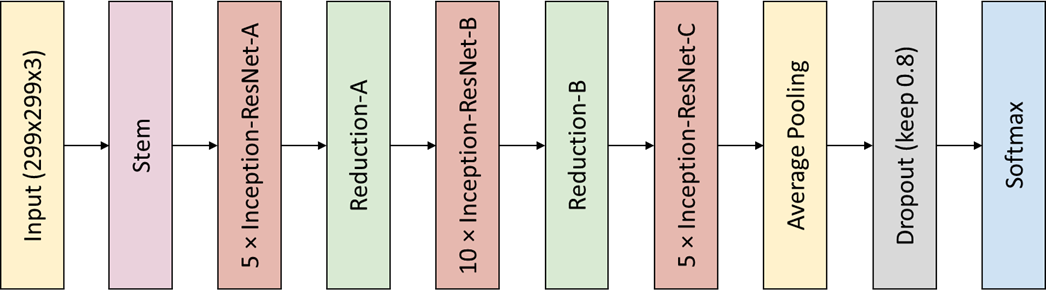

In [32]:
# Base Model

SIZE = 299
incResA_count = 5
incResB_count = 10
incResC_count = 5
initializer = tf.keras.initializers.HeNormal(seed=42)

img_input = Input(shape=(SIZE, SIZE, 3))
x = stem(img_input)

for i in range(incResA_count):
  x = incResA(x, 0.15, name='incResA_'+str(i)+'_')
x = redA(x, name='redA_')

for i in range(incResB_count):
  x = incResB(x, 0.1, name='incResB_'+str(i)+'_')
x = redB(x, name='redB_')

for i in range(incResC_count):
  x = incResC(x, 0.2, name='incResC_'+str(i)+'_')

x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.8)(x)
x = Dense(n_classes, activation='softmax', kernel_initializer=initializer)(x)

# Build & Configure Model

Hyperparameter setting follows the setting proposed by Masand et al. (2021). As for the optimiser, the project will test on 4 types of optimisers (Adam, SGD, SGD + Nesterov, RMSProp).

Hyperparmeter Setting:
*	Batch size = 4
*	Gradient accumulation of batch size = 16  ✅
*	Epochs = 50
*	Learning rate = 0.0001, based on validation loss by a factor of 0.5 and a minimum learning rate of 0.41   ✅
*	Adaptive Gradient Clipping (AGC)
*	Adam, SGD, SGD + Nesterov, RMSProp optimisers
*	Weight initialisation with Gaussian ✅
*	Early stopping patience, reduces by a factor of 2 ✅

In [33]:
base_model = Model(img_input, x, name='inception_resnet_v2')

## Gradient Accumulation

In [155]:
# Ref: https://github.com/bojone/accum_optimizer_for_keras/blob/master/accum_optimizer.py

class AccumOptimizer(Optimizer):
    """Inheriting Optimizer class, wrapping the original optimizer
    to achieve a new corresponding optimizer of gradient accumulation.
    # Arguments
        optimizer: an instance of keras optimizer (supporting
                    all keras optimizers currently available);
        steps_per_update: the steps of gradient accumulation
    # Returns
        a new keras optimizer.
    """
    def __init__(self, optimizer, steps_per_update=1, **kwargs):
        super(AccumOptimizer, self).__init__(name="AccumOptimizer", **kwargs)
        self.optimizer = optimizer
        a = self.optimizer.learning_rate.numpy()
        self.learning_rate = a
        self.lr = a
        with K.name_scope(self.__class__.__name__):
            self.steps_per_update = steps_per_update
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.cond = K.equal(self.iterations % self.steps_per_update, 0)
            # a = self.optimizer.learning_rate.numpy()
            # self.lr = a
            # print( self.optimizer.learning_rate.numpy())
            # print( self.lr)
            self.optimizer.learning_rate = K.eval(K.switch(self.cond, self.optimizer.learning_rate, 0.))  ####
            for attr in ['momentum', 'rho', 'beta_1', 'beta_2']:
                if hasattr(self.optimizer, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
                    setattr(self.optimizer, attr, K.eval(K.switch(self.cond, value, 1 - 1e-7)))
            
            for attr in self.optimizer.get_config():
                if not hasattr(self, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
            # Cover the original get_gradients method with accumulative gradients.
            def get_gradients(loss, params):
                return [ag / self.steps_per_update for ag in self.accum_grads]
            self.optimizer.get_gradients = get_gradients
            

    def get_updates(self, loss, params):
        self.updates = [
            K.update_add(self.iterations, 1),
            K.update_add(self.optimizer.iterations, K.cast(self.cond, 'int64')),
        ]
        # gradient accumulation
        self.accum_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        grads = self.get_gradients(loss, params)
        for g, ag in zip(grads, self.accum_grads):
            self.updates.append(K.update(ag, K.switch(self.cond, ag * 0, ag + g)))
        # inheriting updates of original optimizer
        self.updates.extend(self.optimizer.get_updates(loss, params)[1:])
        self.weights.extend(self.optimizer.weights)
        return self.updates

    def get_config(self):
        iterations = K.eval(self.iterations)
        K.set_value(self.iterations, 0)
        config = self.optimizer.get_config()
        K.set_value(self.iterations, iterations)
        return config

In [149]:
Adam.name = "Adam"

base_model.compile(optimizer=AccumOptimizer(Adam(lr=0.0001), 4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy', 'loss'], run_eagerly=True)

# base_model.compile(optimizer=Adam(lr=0.0001),
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy', 'loss'], run_eagerly=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [116]:
print(Adam(lr=0.0001).learning_rate.numpy())

1e-04


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [157]:
a = AccumOptimizer(Adam(lr=0.0001), 4)
print(a.learning_rate)
print(a.lr)

1e-04


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


AttributeError: ignored

## Early Stopping

In [37]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5, restore_best_weights=True)

## Reduce LR

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.41)

## LR Scheduler

In [152]:
def scheduler(epoch, learning_rate):
  return learning_rate/2
  # return learning_rate

In [153]:
lr_scheduler = LearningRateScheduler(scheduler)

## Model Checkpoint

In [41]:
filepath = "base_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

## Callbacks

In [73]:
# callbacks_list = [early, reduce_lr, lr_scheduler, checkpoint]
callbacks_list = [early, reduce_lr, lr_scheduler, checkpoint]

# Model Training

In [154]:
base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=4), 
                         epochs=50, # one forward/backward pass of training data
                         validation_data=(img_test, label_encoded_test),# data for validation
                        callbacks=callbacks_list)

ValueError: ignored